# Mask R-CNN cells detection

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imutils
import glob
import pandas as pd

import csv
%matplotlib notebook

# Import Mask RCNN
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import save_image
# Import Cells config
import Cells

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join("logs")

# Local path to trained weights file
CELL_MODEL_PATH = os.path.join("mask_rcnn_cells_0100.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(CELL_MODEL_PATH):
    utils.download_trained_weights(CELL_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join("images")

C:\Users\hafiz\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hafiz\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hafiz\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hafiz\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Configurations

We'll be using a model trained on the biofilm dataset. The configurations of this model are in the ```CellsConfig``` class in ```Cells.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CellsConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(Cells.CellsConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(CELL_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names
We're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1)

In [4]:
# CELL Class names
# Index of the class in the list is its ID. For example, to get ID of
# the cells class, use: class_names.index('cells')
class_names = ['BG', 'cells']

## Run Object Detection

Processing 1 images
image                    shape: (229, 256, 3)         min:    3.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


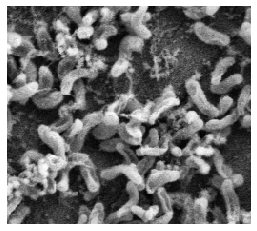

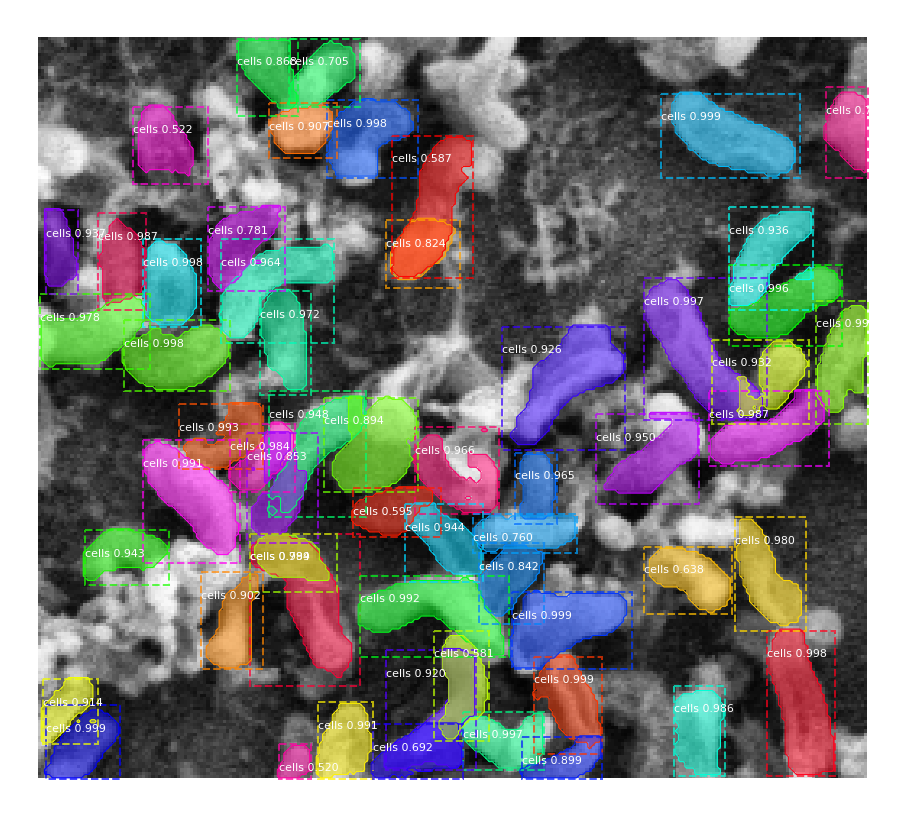

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
images = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = cv2.cvtColor(images,cv2.COLOR_GRAY2RGB)

# Run detection
results = model.detect([image], verbose=1)


#Orginal Image
plt.imshow(image)
plt.axis("off")
plt.show()

# Visualize the final results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']) 

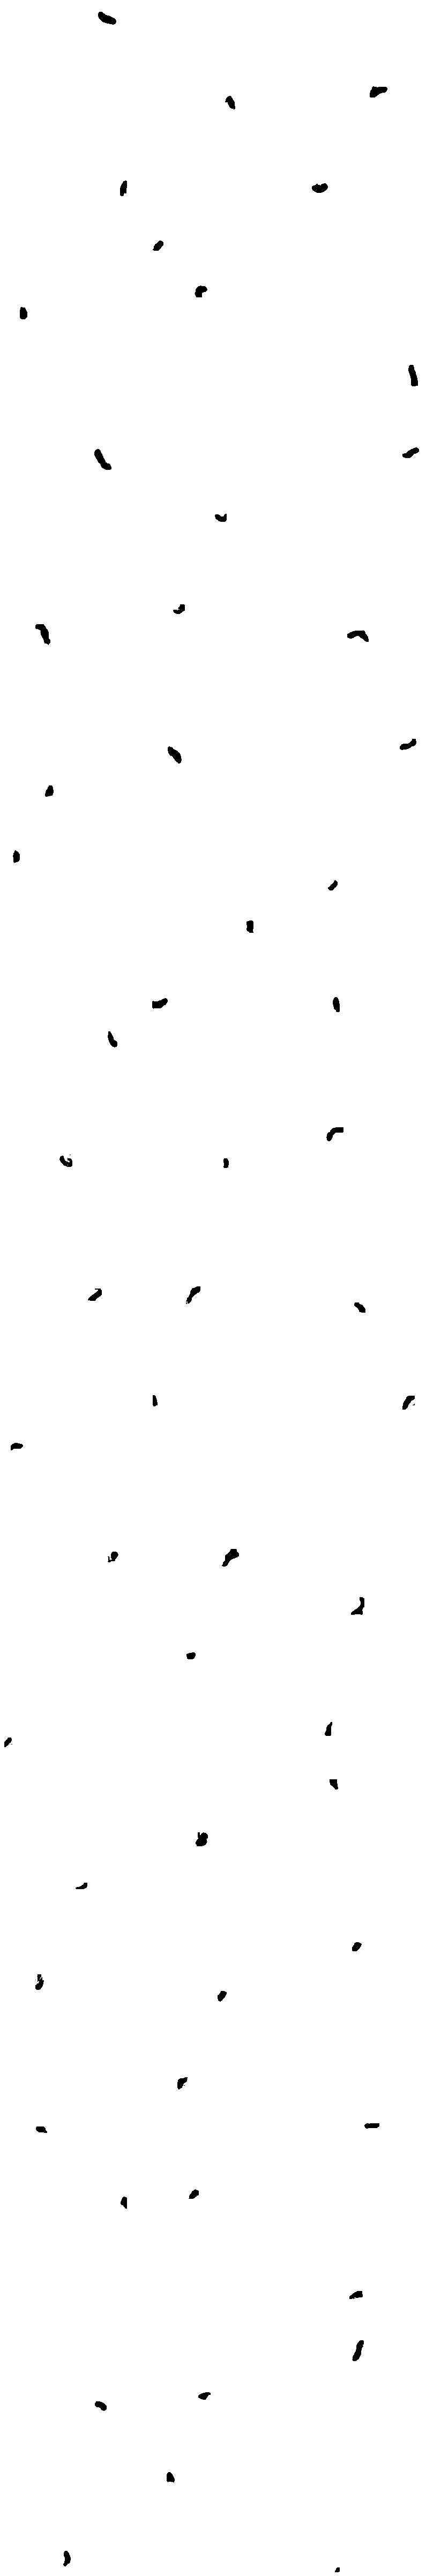

In [6]:
# Visualize the individual cells mask
display_images(np.transpose(r['masks'], [2, 0, 1]), cols=3, cmap="gray_r",)

In [7]:
#Load the mask for individual cells
mask = r['masks']
mask = mask.astype(int)
mask.shape

(229, 256, 57)

In [8]:
lis=[["Number of Cells", "Area", "Perimeter", "Width", "Height"]]
i=0
for i in range(mask.shape[2]):
    file_names = next(os.walk(IMAGE_DIR))[2]
    image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    image_r = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images = imutils.resize(image_r, height=229, width=256)
    for j in range(images.shape[2]):
        images[:,:,j] = images[:,:,j] * mask[:,:,i]
        
    #convert the individual cells mask into binary image
    gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (1,1), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    #use contours function foe calculation area, perimeter, height, and width of the idividual cells.
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 5500:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    bin_img = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    #area of individual cells
    area=0
    for m in range (bin_img.shape[0]): #traverses through height of the image
        for n in range (bin_img.shape[1]): #traverses through width of the image
            if bin_img[m][n] !=0:
                area=area+1
                    
    contours, hierarchy = cv2.findContours(bin_img ,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image, [cnt], 0,(255, 0, 0), 1)
        
        #perimeter of individual cells
        perimeter = cv2.arcLength(cnt,True)
        #Height and width of individual cells
        (x, y), (width, height), angle = rect
        if width>height:
            height_n=width
            width_n=height
        else:
            height_n=height
            width_n=width
    i+=1  
    #create a csv file name "cell_features.csv", where we store the values of 
    #area, perimeter, height, and width of the idividual cells.
    lis.append([i, area, perimeter, width_n, height_n]) 
    f = open("Outputs/cell_features.csv", 'w', newline='')
    for item in lis:
        csv.writer(f).writerow(item)
    f.close() 
    #save all individual cells mask as binary image.
    filename = "Outputs/binary_img/segment_%d.jpg"%i
    cv2.imwrite(filename, bin_img)

C:\Users\hafiz\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


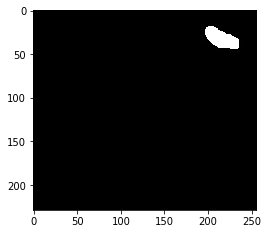

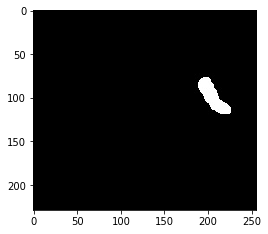

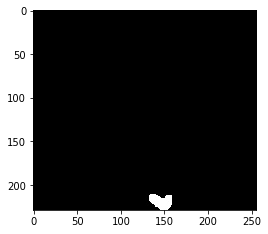

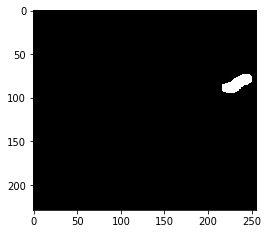

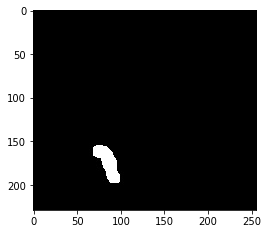

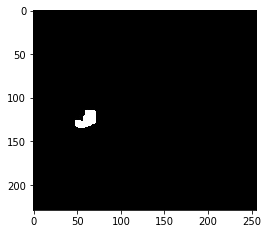

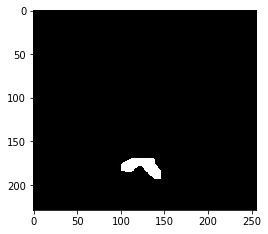

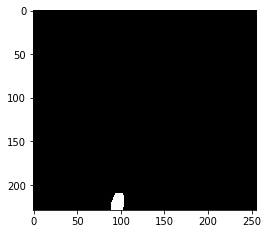

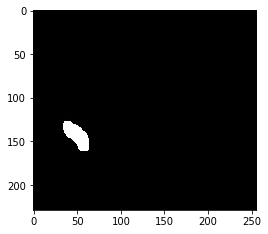

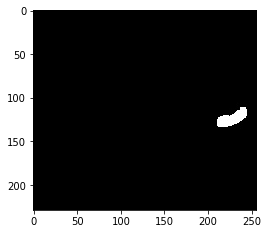

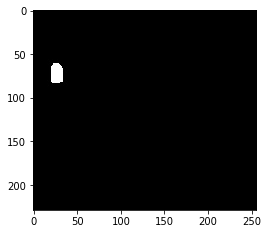

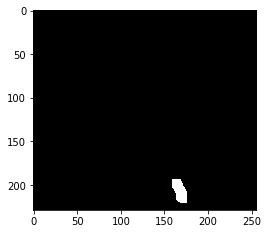

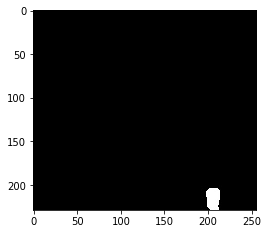

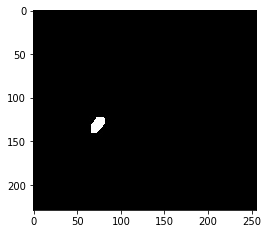

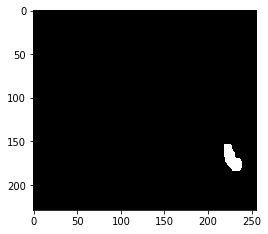

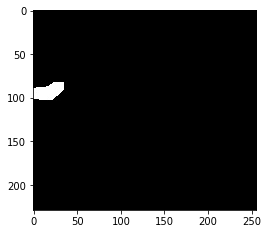

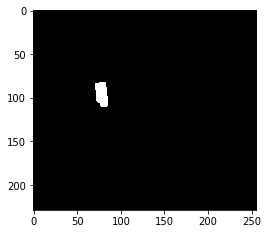

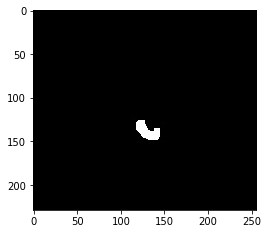

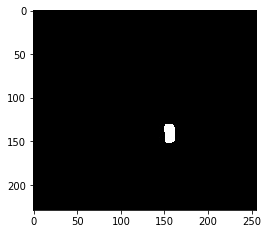

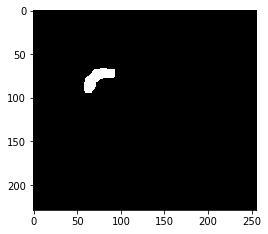

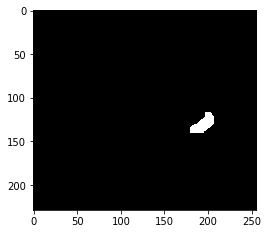

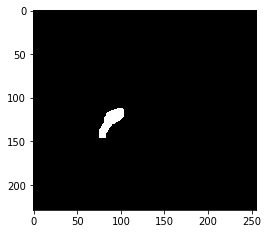

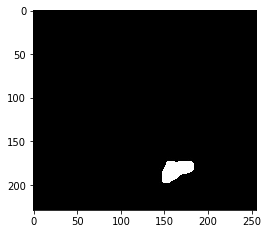

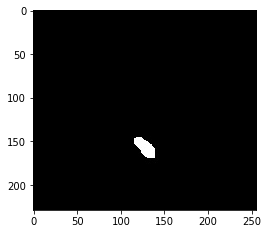

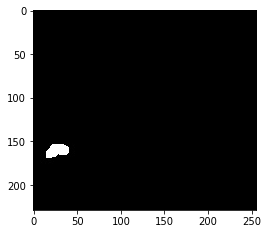

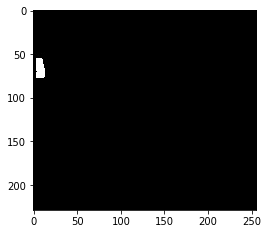

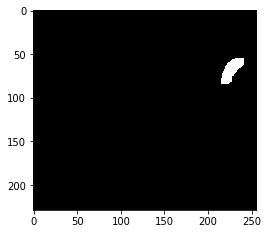

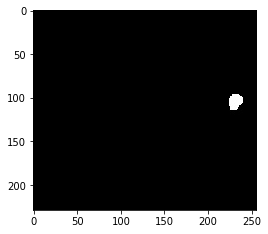

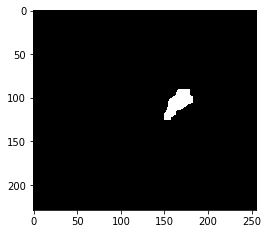

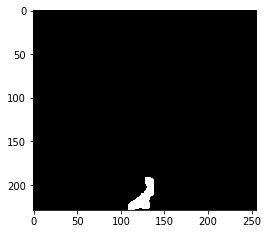

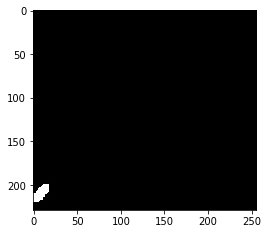

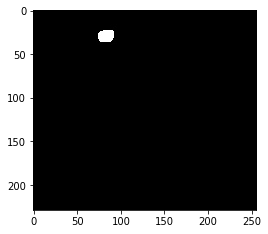

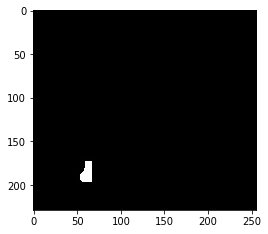

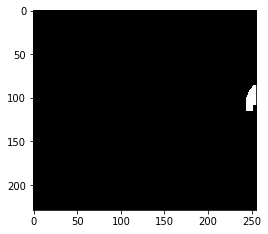

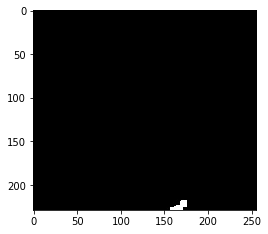

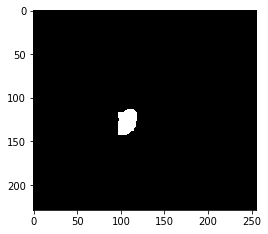

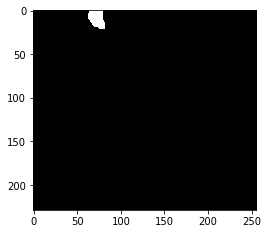

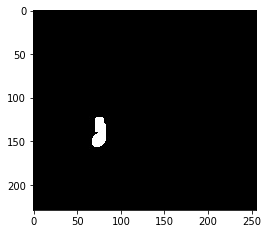

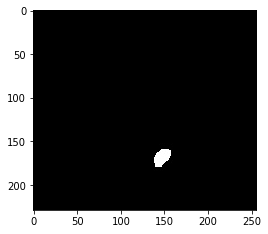

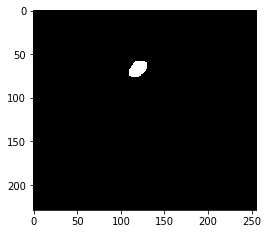

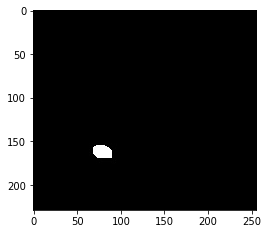

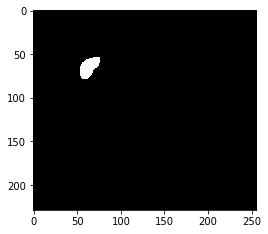

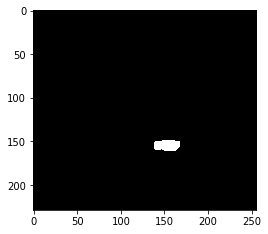

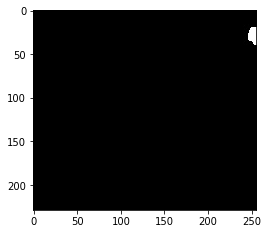

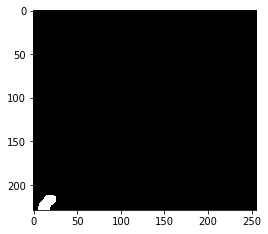

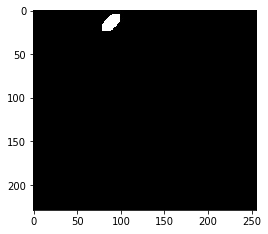

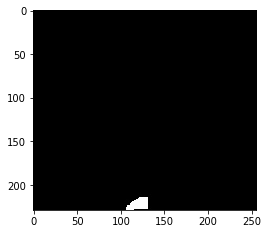

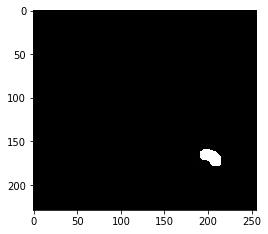

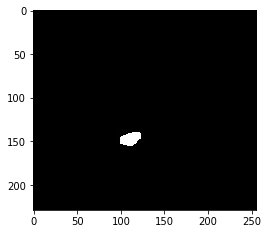

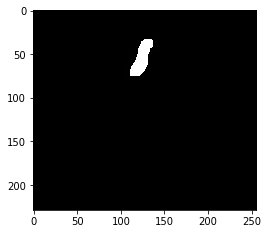

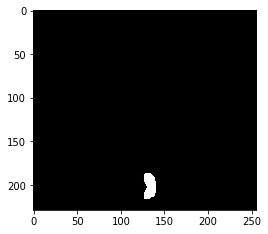

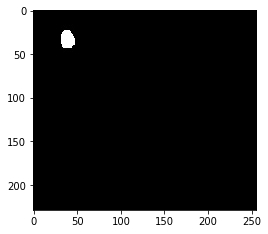

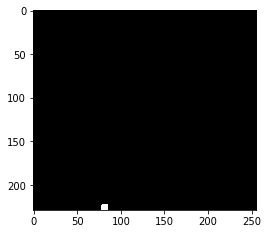

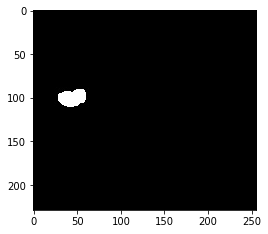

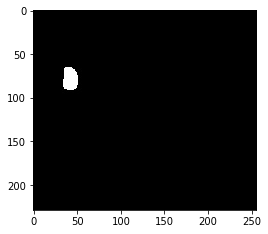

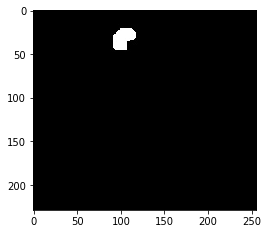

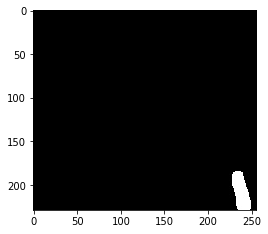

In [9]:
# Visualize the individual cells mask in binary format
for img in glob.glob("Outputs/binary_img/*.jpg"):
    cv_img = cv2.imread(img)
    plt.figure(figsize=(4,4))
    plt.imshow(cv_img)

In [10]:
# Visualize the csv file
import pandas as pd
df=pd.read_csv('Outputs/cell_features.csv')  
df.set_index(['Number of Cells'], inplace=True)
#the values of area, perimeter, width, and height of bacterial cells are in Pixel.
df

,Area,Perimeter,Width,Height
Number of Cells,,,,
1,656,108.083260,18.642845,42.973888
2,340,76.041630,13.497612,30.585014
3,643,106.183766,24.000000,36.000000
4,292,75.556349,12.000000,29.000000
5,243,61.213203,16.000000,19.000000
6,502,87.941125,18.384777,31.961227
7,401,74.870057,17.000000,26.000000
8,488,87.698484,24.000000,26.000000
9,671,116.526911,16.669872,46.283409
